In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
import torch
import torch.nn as nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

In [3]:
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [5]:
def free_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
articles = pd.read_json('data/articles/train.json')
articles.drop_duplicates(subset=['text'], inplace=True)
articles.set_index('id', inplace=True)
articles.head(10)

,text,sentiment
id,,
1945,Досудебное расследование по факту покупки ЕНПФ...,negative
1957,Медики рассказали о состоянии пострадавшего му...,negative
1969,"Прошел почти год, как железнодорожным оператор...",negative
1973,По итогам 12 месяцев 2016 года на территории р...,negative
1975,Астана. 21 ноября. Kazakhstan Today - Агентств...,negative
1980,Об аресте бывшего министра национальной эконом...,negative
1982,Двое налетчиков совершили нападение на охранни...,negative
1983,"""Самрук-Энерго"" в I квартале почти вдвое снизи...",negative
1985,В 2016 году почти половина коррупционных прест...,negative


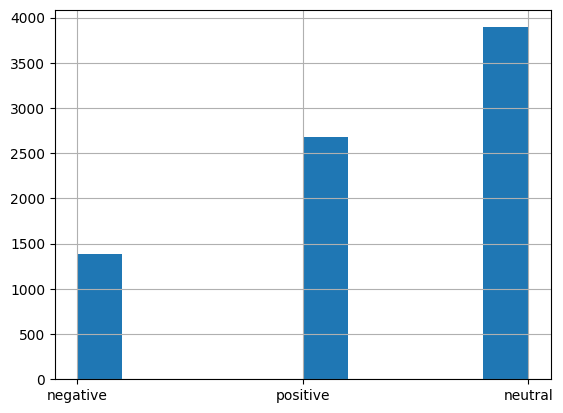

In [7]:
articles.sentiment.hist()
plt.show()

In [8]:
sentiment_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

In [9]:
articles.sentiment = articles.sentiment.apply(lambda x: sentiment_map[x])
articles.head(10)

,text,sentiment
id,,
1945,Досудебное расследование по факту покупки ЕНПФ...,0
1957,Медики рассказали о состоянии пострадавшего му...,0
1969,"Прошел почти год, как железнодорожным оператор...",0
1973,По итогам 12 месяцев 2016 года на территории р...,0
1975,Астана. 21 ноября. Kazakhstan Today - Агентств...,0
1980,Об аресте бывшего министра национальной эконом...,0
1982,Двое налетчиков совершили нападение на охранни...,0
1983,"""Самрук-Энерго"" в I квартале почти вдвое снизи...",0
1985,В 2016 году почти половина коррупционных прест...,0


In [10]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [11]:
pretrained_model_name_or_path = 'sberbank-ai/rugpt3small_based_on_gpt2'

In [12]:
gpt = GPT2LMHeadModel.from_pretrained(pretrained_model_name_or_path)
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path)

In [13]:
gpt

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

In [14]:
for param in gpt.parameters():
    param.requires_grad = False

In [15]:
num_labels = articles.sentiment.nunique()
num_labels

3

In [16]:
gpt.lm_head = nn.Linear(gpt.config.hidden_size, num_labels)
gpt = gpt.to(device)
gpt

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=3, bias=True)
)

In [17]:
X = articles.text
y = articles.sentiment

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
tokenizer.pad_token_id = 0
print(tokenizer.pad_token)

<pad>


In [20]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, X, y, tokenizer=None, num_labels=3):
        self.X = tokenizer(X.tolist(), 
                           truncation=True, 
                           padding=True,
                           return_tensors="pt",
                           max_length=2048).to(device)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.int64).to(device)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X.input_ids[idx], self.X.attention_mask[idx], self.y[idx]

In [21]:
train_dataset = SentimentAnalysisDataset(X_train, y_train, tokenizer)
test_dataset = SentimentAnalysisDataset(X_test, y_test, tokenizer)

free_memory()

In [22]:
batch_size = 16
num_epochs = 12

In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [24]:
optimizer = AdamW(gpt.lm_head.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [25]:
def evaluate_model(model, data_loader):
    ground_truth = []
    predictions = []

    model.eval()
    for input_ids, attention_mask, labels in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = torch.mean(outputs.logits, dim=1)
        _, indices = torch.max(logits, 1)
        predictions.extend(indices.tolist())
        ground_truth.extend(labels.tolist())
        del input_ids
        del attention_mask
        del labels
        del outputs
        del logits
        del indices
        free_memory()
    accuracy = accuracy_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions, average='macro')
    del predictions
    del ground_truth
    free_memory()
    return accuracy, f1

In [26]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, 
                step_size=1, gamma=0.5):
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss_history = []
    train_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (input_ids, attention_mask, y) in enumerate(train_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            y = y.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = torch.mean(outputs.logits, dim=1)
            optimizer.zero_grad()
            loss = criterion(logits, y)
            loss.backward()
            clip_grad_norm_(model.lm_head.parameters(), 1.0)
            optimizer.step()
            
            _, indices = torch.max(logits, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            loss_accum += loss
            
            del outputs
            del logits
            del indices
            del input_ids
            del attention_mask
            del y
            free_memory()
          
        scheduler.step()
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        
        free_memory()

        print("Average loss: %f, Train accuracy: %f" % (ave_loss, train_accuracy))
        
    return loss_history, train_history

In [27]:
loss_history, train_history = train_model(gpt, 
                                          train_loader, 
                                          criterion, 
                                          optimizer, num_epochs)

Average loss: 1.055959, Train accuracy: 0.601038
Average loss: 0.840529, Train accuracy: 0.654977
Average loss: 0.707420, Train accuracy: 0.692090
Average loss: 0.654136, Train accuracy: 0.714578
Average loss: 0.630785, Train accuracy: 0.722755
Average loss: 0.617199, Train accuracy: 0.732348
Average loss: 0.604172, Train accuracy: 0.739110
Average loss: 0.603074, Train accuracy: 0.735965
Average loss: 0.600218, Train accuracy: 0.737852
Average loss: 0.598015, Train accuracy: 0.739110
Average loss: 0.597207, Train accuracy: 0.740368
Average loss: 0.598599, Train accuracy: 0.736437


In [28]:
free_memory()

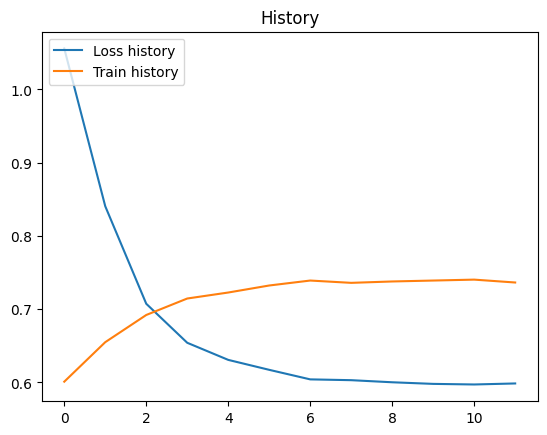

In [29]:
plt.title("History")
plt.plot(loss_history, label="Loss history")
plt.plot(train_history, label="Train history")
plt.legend(loc="upper left")
plt.show()

In [30]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [31]:
accuracy, f1 = evaluate_model(gpt, test_loader)
print(f"Test accuracy is {accuracy}")
print(f"Test f1 score is {f1}")

Test accuracy is 0.6918238993710691
Test f1 score is 0.6757975051687976


In [32]:
articles_test = pd.read_json('data/articles/test.json')
articles_test['sentiment'] = pd.Series([0] * len(articles_test), dtype=int)
articles_test.head(10)

,text,id,sentiment
0,"Как сообщает пресс-служба акимата Алматы, для ...",0,0
1,Казахстанские авиакомпании перевозят 250 тысяч...,1,0
2,На состоявшемся под председательством Касым-Жо...,2,0
3,В ОАЭ состоялись переговоры между казахстанско...,3,0
4,12 вагонов грузового поезда сошли с путей в Во...,4,0
5,Отправившиеся на «джихад» из города Сатпаева К...,5,0
6,\nНазарбаев утвердил новый состав правительств...,6,0
7,ШЫМКЕНТ. КАЗИНФОРМ - В Шардаринском районе Южн...,7,0
8,С 5 августа 2011 года вступил в юридическую с...,8,0
9,Казахстанцы должны платить за коммунальные усл...,9,0


In [33]:
def classify(model, text, tokenizer):
    model.eval()
    input_ids = tokenizer.encode(text, return_tensors='pt', truncation=True, 
                                 max_length=2048)
    input_ids = input_ids.to(device)
    outputs = model(input_ids=input_ids)
    logits = torch.mean(outputs.logits, dim=1)
    _, indices = torch.max(logits, 1)
    return int(indices)

In [35]:
articles_test['sentiment'] = articles_test['text']\
    .apply(lambda text: classify(gpt, text, tokenizer))
articles_test.head(10)

,text,id,sentiment
0,"Как сообщает пресс-служба акимата Алматы, для ...",0,1
1,Казахстанские авиакомпании перевозят 250 тысяч...,1,2
2,На состоявшемся под председательством Касым-Жо...,2,1
3,В ОАЭ состоялись переговоры между казахстанско...,3,1
4,12 вагонов грузового поезда сошли с путей в Во...,4,0
5,Отправившиеся на «джихад» из города Сатпаева К...,5,0
6,\nНазарбаев утвердил новый состав правительств...,6,2
7,ШЫМКЕНТ. КАЗИНФОРМ - В Шардаринском районе Южн...,7,2
8,С 5 августа 2011 года вступил в юридическую с...,8,1
9,Казахстанцы должны платить за коммунальные усл...,9,1


In [36]:
articles_test['sentiment'] = articles_test['sentiment']\
    .map({v: k for k, v in sentiment_map.items()})
articles_test.head(10)

,text,id,sentiment
0,"Как сообщает пресс-служба акимата Алматы, для ...",0,neutral
1,Казахстанские авиакомпании перевозят 250 тысяч...,1,positive
2,На состоявшемся под председательством Касым-Жо...,2,neutral
3,В ОАЭ состоялись переговоры между казахстанско...,3,neutral
4,12 вагонов грузового поезда сошли с путей в Во...,4,negative
5,Отправившиеся на «джихад» из города Сатпаева К...,5,negative
6,\nНазарбаев утвердил новый состав правительств...,6,positive
7,ШЫМКЕНТ. КАЗИНФОРМ - В Шардаринском районе Южн...,7,positive
8,С 5 августа 2011 года вступил в юридическую с...,8,neutral
9,Казахстанцы должны платить за коммунальные усл...,9,neutral


In [37]:
articles_test[['id', 'sentiment']].to_csv('output.csv', index=False)

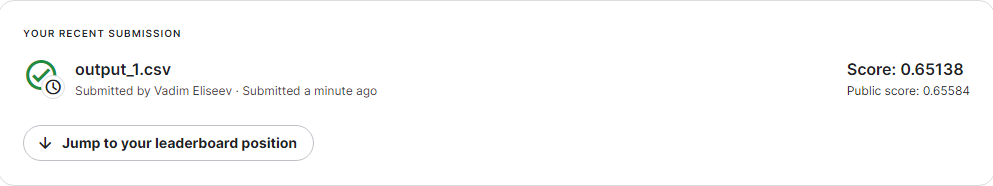

In [38]:
torch.save(gpt, 'lt_sberbank-gpt-sentiment-classifier.pth')